In [3]:
import time

import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from util import display_image

## remapping (arbitrary mapping)
* cv.remap(src, mapx, mapy, interpolation, ...)
    - mapx: x axis after transformation
    - mapy: y axis after transformation
    
* e.g.
    - mapx[0][0] = 10, mapy[0][0] = 5
    - (0, 0) $\rightarrow$ (10, 5)

* initialize mapx, mapy with original imgae
    - its convenient keeping pixels with original value that does not wants to applying transformation
    
* arr.itemset((0, 0), 10) is faster than arr[0][0] = 10

* cv.remap automatically adjust re-mapped coordinate that does not divided by integer

## flip image

$$x' = x + d_x$$
$$y' = y + d_y$$
$$
\begin{bmatrix}
x'\\
y'
\end{bmatrix} = 
\begin{bmatrix}
-1 & 0 & cols-1\\
0 & -1 & rows-1
\end{bmatrix}
\begin{bmatrix}
x \\
y \\
1
\end{bmatrix}
$$

In [2]:
img = cv.imread('../img/girl.jpg')
rows, cols = img.shape[:2]

* numpy operator

In [6]:
st = time.time()

mflip = np.float32([
    [-1, 0, cols-1],
    [0, -1, rows-1]
])
fliped1 = cv.warpAffine(img, mflip, (cols, rows))

print('matrix: ', time.time() - st)

matrix:  0.00048089027404785156


* cv operatorst = time.time()

In [24]:
s2 = time.time()

mapy, mapx = np.indices((rows, cols), dtype=np.float32)
mapx = cols - mapx - 1
mapy = rows - mapy - 1
fliped2 = cv.remap(img, mapx, mapy, cv.INTER_LINEAR)

print('remap: ', time.time() - st)

remap:  228.93739461898804


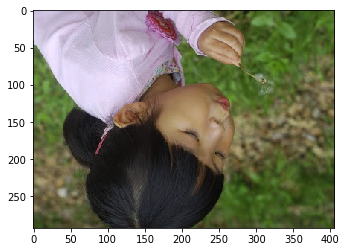

In [25]:
display_image(fliped1)

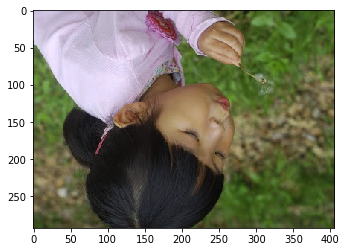

In [26]:
display_image(fliped2)

## non-linear mapping with trigonometric function

In [27]:
l = 20
amp = 15

In [34]:
img = cv.imread('../img/taekwonv1.jpg')

In [35]:
rows, cols = img.shape[:2]

In [36]:
mapy, mapx = np.indices((rows, cols), dtype=np.float32)

In [37]:
sinx = mapx + amp*np.sin(mapy/l)
cosy = mapy + amp*np.cos(mapx/l)

In [47]:
img_sinx = cv.remap(img, sinx, mapy, cv.INTER_LINEAR)
img_cosy = cv.remap(img, mapx, cosy, cv.INTER_LINEAR)
img_both = cv.remap(img, sinx, cosy, cv.INTER_LINEAR)

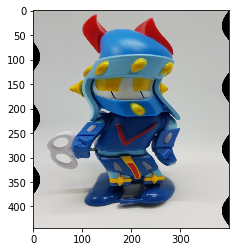

In [43]:
display_image(img_sinx)

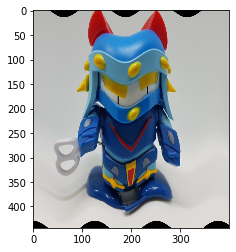

In [46]:
display_image(img_cosy)

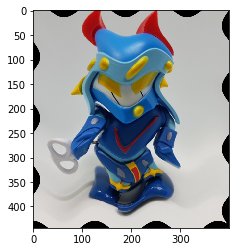

In [48]:

display_image(img_both)

## convex, concave lens effects

* catesian coordinate $\rightarrow$ polar coordinate
* see
    - cv.cartToPolar
    - cv.polarToCart

In [69]:
img = cv.imread('../img/taekwonv1.jpg')

In [70]:
rows, cols = img.shape[:2]

In [112]:
# convex (>1)
# exp = 3
# concave (0-1)
exp = 0.5
scale = 1

In [113]:
mapy, mapx = np.indices((rows, cols), dtype=np.float32)

In [114]:
# important: normalize x, y with [-1 ~ 1]
mapx = 2*mapx / (cols-1) -1
mapy = 2*mapy / (rows-1) -1

In [115]:
r, theta = cv.cartToPolar(mapx, mapy)

In [116]:
# scale distorting regions
r[r < scale] = r[r < scale]**exp

In [117]:
mapx, mapy = cv.polarToCart(r, theta)

In [118]:
mapx = ((mapx+1)*cols - 1)/2
mapy = ((mapy+1)*rows - 1)/2

In [119]:
distored = cv.remap(img, mapx, mapy, cv.INTER_LINEAR)

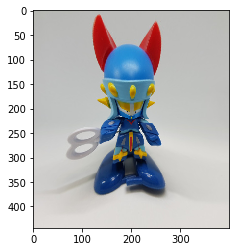

In [120]:
display_image(distored)

## barrel distortion
* more distortions on central region of image
    - since, camera lens is circular and image is rectangular

$$r_d = r_u (1+k_1 r_u^2 + k_2r_u^4 + k_3r_u^6)$$

* Notations
    - $r_d$: before distortion
    - $r_u$: after distortion
    - $k_i$: distortion coefficients

In [121]:
img = cv.imread('../img/taekwonv1.jpg')
rows, cols = img.shape[:2]

In [132]:
# barrel
k1, k2, k3 = 0.5, 0.2, 0.0
# pincushion
k1, k2, k3 = -0.3, 0, 0

In [133]:
mapy, mapx = np.indices((rows, cols), dtype=np.float32)

In [134]:
# important: normalize x, y with [-1 ~ 1]
mapx = 2*mapx / (cols-1) -1
mapy = 2*mapy / (rows-1) -1

In [135]:
r, theta = cv.cartToPolar(mapx, mapy)

In [136]:
ru = r*(1+k1*r**2 + k2*r**4 + k3*r**6)

In [137]:
mapx, mapy = cv.polarToCart(ru, theta)

In [138]:
mapx = ((mapx + 1)*cols -1)/2
mapy = ((mapy + 1)*rows -1)/2

In [139]:
distored = cv.remap(img, mapx, mapy, cv.INTER_LINEAR)

* barrel

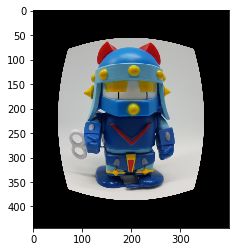

In [131]:
display_image(distored)

* pincushion

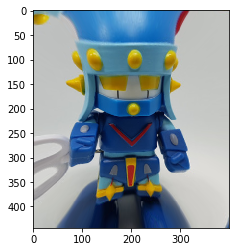

In [140]:
display_image(distored)

## cv.undistort: removing barrel distortion effect

* cv.undistort(src, cameraMtrix, distCoeffs)
    - src: input raw image
    - cameraMatrix: camera matrix (unique characters)
$$
\begin{bmatrix}
f_x & 0 & c_x\\
0 & f_y & c_y\\
0 & 0 & 1
\end{bmatrix}
$$
        - $c_x,\;c_y$: center points
        - $f_x,\;f_y$: focal length
    - distcCoeffs: distortion coefficients (at leat 4 or 5, 8, 12, 14)
        - $(k1,\;k2,\;p1,\;p2[,\;k3])$

In [157]:
img = np.full((300, 400, 3), 255, np.uint8)

In [159]:
img[::10, :, :] = 0
img[:, ::10, :] = 0

In [160]:
height, width = img.shape[:2]
print(height, width)

300 400


In [169]:
# set distortion coefficeint
k1, k2, p1, p2 = 0.001, 0, 0, 0
distCoeff1 = np.float64([k1, k2, p1, p2])

k1, k2, p1, p2 = -0.0005, 0, 0, 0
distCoeff2 = np.float64([k1, k2, p1, p2])

In [170]:
def cv_undist(img, dist_coef):
    
    height, width = img.shape[:2]

    fx, fy = 10, 10
    cx, cy = width/2, height/2
    camMtx = np.float32([
        [fx, 0, cx],
        [0, fy, cy],
        [0, 0, 1]
    ])

    dst = cv.undistort(img, camMtx, dist_coef)
    
    return dst

In [171]:
dst1 = cv_undist(img, distCoeff1)
dst2 = cv_undist(img, distCoeff2)

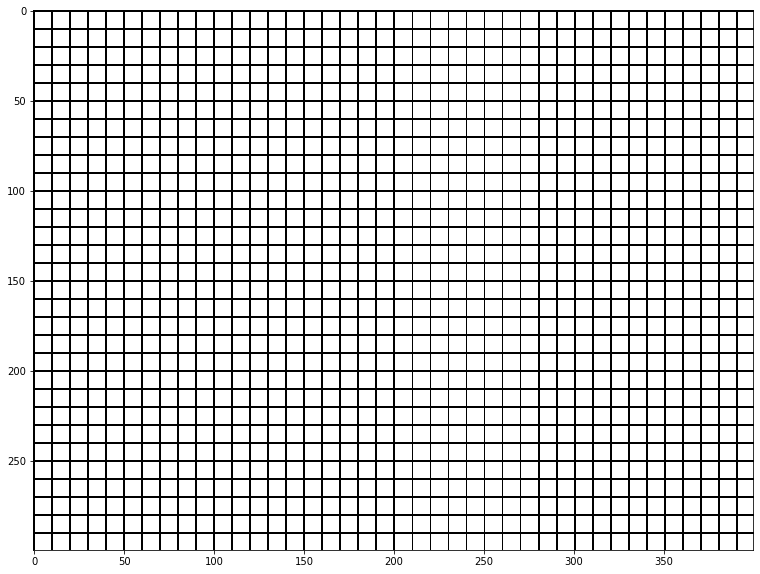

In [172]:
display_image(img, right=2, top=2)

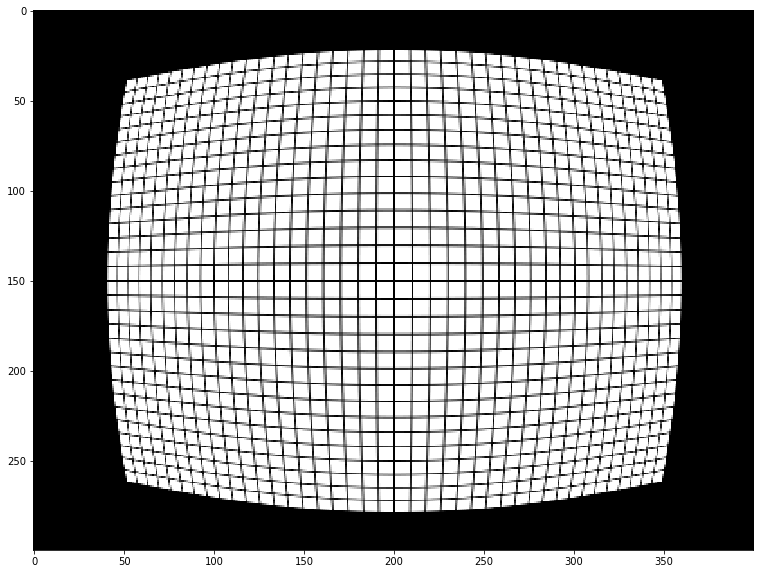

In [173]:
display_image(dst1, right=2, top=2)

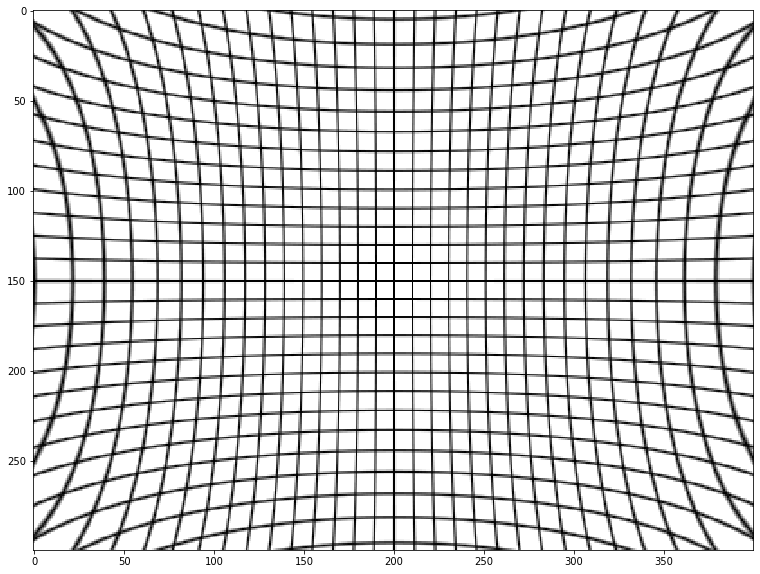

In [174]:
display_image(dst2, right=2, top=2)

## Exercise: mosaic

In [249]:
# reducing ratio (1/rate)
rate = 15

In [250]:
img = cv.imread('../img/taekwonv1.jpg')

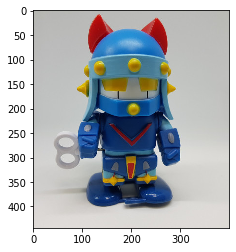

In [251]:
display_image(img)

In [252]:
y = 125
h = 75
x = 125
w = 145

In [253]:
roi = img[y:y+h, x:x+w]

(75, 145, 3)

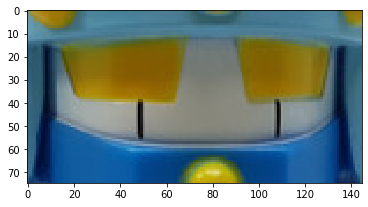

In [254]:
display_image(roi)
roi.shape

In [255]:
roi = cv.resize(roi, (w//rate, h//rate))

(5, 9, 3)

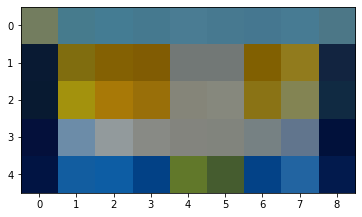

In [256]:
display_image(roi)
roi.shape

In [257]:
# roi = cv.resize(roi, (w, h), interpolation=cv.INTER_CUBIC) # less 
roi = cv.resize(roi, (w, h), interpolation=cv.INTER_AREA)

(75, 145, 3)

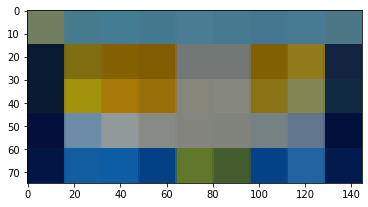

In [258]:
display_image(roi)
roi.shape

In [259]:
img[y:y+h, x:x+w] = roi

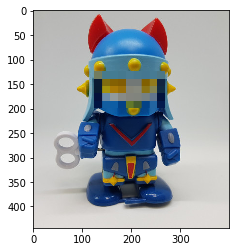

In [260]:
display_image(img)